# Minimal LGBM regressor

A simple LGBM ecfp4 model implemented in pure scikit-learn + datamol for protyping purposes

In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from molfeat.trans import MoleculeTransformer
from molfeat.trans.fp import FPVecTransformer
import datamol as dm
from sklearn.model_selection import GridSearchCV


In [2]:
CYP3A4_chembl_pchembl = '../tests/test_data/CYP3A4_chembl_pchembl.csv'
data = pd.read_csv(CYP3A4_chembl_pchembl)

In [3]:
data.head()

,CANONICAL_SMILES,INCHIKEY,pChEMBL mean,pChEMBL std,common_name,appears_in_N_ChEMBL_assays,action_type,dataset,active
0,CC(=O)N1CCN(c2ccc(OCC3COC(Cn4ccnc4)(c4ccc(Cl)c...,XMAYWYJOQHXEEK-UHFFFAOYSA-N,7.013500,0.618796,KETOCONAZOLE,21,NaN,ChEMBL_curated,True
1,CCC1C(=O)OC[C@H]1Cc1cncn1C,QCHFTSOMWOSFHM-HNHGDDPOSA-N,5.052941,0.285302,SALAGEN,17,NaN,ChEMBL_curated,True
2,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,VNFPBHJOKIVQEB-UHFFFAOYSA-N,7.237692,0.358798,CLOTRIMAZOLE,14,NaN,ChEMBL_curated,True
3,CNCCCC12CCC(c3ccccc31)c1ccccc12,QSLMDECMDJKHMQ-UHFFFAOYSA-N,5.473846,0.281470,MAPROTILINE HYDROCHLORIDE,13,NaN,ChEMBL_curated,True
4,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,BYBLEWFAAKGYCD-UHFFFAOYSA-N,6.060000,0.608590,MICONAZOLE NITRATE,12,NaN,ChEMBL_curated,True


In [4]:
X = data["CANONICAL_SMILES"]
y = data["pChEMBL mean"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [6]:
vec_featurizer = FPVecTransformer("ecfp:4", dtype=np.float32)
trans = MoleculeTransformer(
            vec_featurizer,
            n_jobs=-1,
            dtype=np.float32,
            parallel_kwargs={"progress": True},
            verbose=False,
        )

In [7]:
with dm.without_rdkit_log():
    X_train_feat, _ =  trans(X_train, ignore_errors=True)
    X_test_feat, _ = trans(X_test, ignore_errors=True)


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 5964/5964 [00:01<00:00, 3140.66it/s]
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be remov

In [8]:
regressor = LGBMRegressor()

In [9]:
X_train_feat = np.squeeze(X_train_feat)
X_test_feat = np.squeeze(X_test_feat)

In [10]:
param_grid = {
    'learning_rate': [0.001, 0.05, 0.1, 0.5],  
    'n_estimators': [100, 200, 400],  

}


In [11]:
grid_search = GridSearchCV(regressor, param_grid)

In [12]:
grid_search.fit(X_train_feat, y_train)

/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1693
[LightGBM] [Info] Start training from score 5.600126


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.597832


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1697
[LightGBM] [Info] Start training from score 5.609658


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1691
[LightGBM] [Info] Start training from score 5.604411


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 1691
[LightGBM] [Info] Start training from score 5.606042


/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3608
[LightGBM] [Info] Number of data points in the train set: 5964, number of used features: 1804
[LightGBM] [Info] Start training from score 5.603614


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.001, 0.05, 0.1, 0.5],
                         'n_estimators': [100, 200, 400]})

In [13]:
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.05, 'n_estimators': 200}


In [14]:
y_pred = grid_search.predict(X_test_feat)

/Users/dwwest/miniconda3/envs/openadmet_models/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
import seaborn as sns

<Axes: xlabel='pChEMBL mean'>

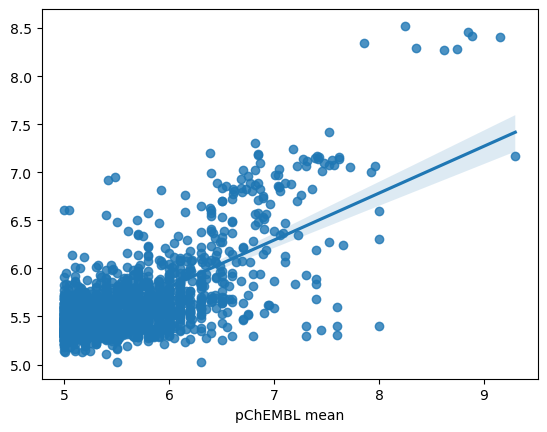

In [16]:
sns.regplot(x=y_test, y=y_pred)

In [17]:
from polaris_model_comparison import *

In [18]:
data_for_stats = pd.DataFrame()
thresh =6.

data_for_stats['pchembl'] = y_test
data_for_stats['pchembl_pred'] = y_pred
data_for_stats['fold'] = np.ones(len(y_test))
data_for_stats['method'] = np.ones(len(y_test))
data_for_stats['split'] = np.ones(len(y_test))
data_for_stats['cv_cycle'] = np.ones(len(y_test))
metrics = calc_regression_metrics(data_for_stats, "fold", "pchembl", "pchembl_pred", thresh)
metric_ls = metrics.columns[3:]

df_split = metrics.query("split == 1")
metrics

,cv_cycle,method,split,mae,mse,r2,rho,prec,recall
0,1.0,1.0,1.0,0.29886,0.164036,0.496444,0.478164,0.808511,0.462006


pred_class
False    1801
True      188
Name: count, dtype: int64
true_class
False    1660
True      329
Name: count, dtype: int64


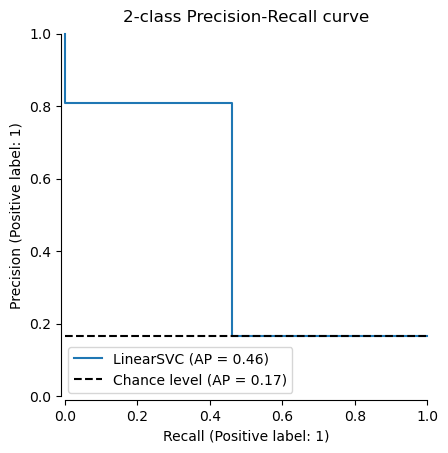

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np

random_state = np.random.RandomState(0)
pred_class = data_for_stats["pchembl_pred"] > thresh
true_class = data_for_stats["pchembl"] > thresh
display = PrecisionRecallDisplay.from_predictions(
    true_class, pred_class, name="LinearSVC", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
data_for_stats["pred_class"] = pred_class
data_for_stats["true_class"] = true_class
print(data_for_stats["pred_class"].value_counts())
print(data_for_stats["true_class"].value_counts())
# only have one classification, need a function of the threshold


In [20]:
# from scipy.stats import levene
# for metric in metric_ls:
#     groups = df_split.groupby('method')[metric].apply(list)
#     stat, pvalue = levene(*groups)
#     print(f'Levene test for {metric}: p-value = {pvalue}')
# variances_by_method = df_split.groupby('method')[metric_ls].var()
# max_fold_diff = variances_by_method.max() / variances_by_method.min()

In [21]:
# Need to check that the variances of the metrics are normal, but need splits for that

In [22]:
# df_scaffold_in = data_for_stats.query("split == 1")
# make_scatterplot(df_scaffold_in, "pchembl", "pchembl_pred", thresh=5.5, cycle_col="cv_cycle", group_col="method") 

In [23]:

import umap
def visualize_chemspace(data: pd.DataFrame, split_names: List[str], mol_col: str = "smiles", size_col=None):
    figs = plt.figure(num=3)
    features = [dm.to_fp(mol) for mol in data[mol_col]]
    embedding = umap.UMAP().fit_transform(features)
    data["UMAP_0"], data["UMAP_1"] = embedding[:, 0], embedding[:, 1]
    for split_name in split_names:
        plt.figure()
        fig = sns.scatterplot(data=data, x="UMAP_0", y="UMAP_1", style=size_col, hue=split_name, alpha=0.7)
        fig.set_title(f"UMAP Embedding of compounds for {split_name}")
    return figs

AttributeError: `np.infty` was removed in the NumPy 2.0 release. Use `np.inf` instead.

In [29]:
import pandas as pd
import splito
import splito.utils
import matplotlib.pyplot as plt
import os
import sys

current_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from split import scaffold

path = '../tests/test_data/CYP3A4_chembl_pchembl.csv'
data = pd.read_csv(path)

splitter = scaffold.PerimeterSplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data["SMILES"].values))



ModuleNotFoundError: No module named 'openadmet_models'